# Initial notebook, final project in 42186 Model Based Machine Learning
### Frederik Boe Hüttel (s151689), Mathias Niemann Tygesen (s153583) and David Frich Hansen (s144242)
---
This is the initial notebook for the final project in 42186 Model Based Machine Learning.  


#### The data
We have chosen slightly alternative approach to Bayesian modeling through PGM's than what has been taught in the course. The main difference is, that we have chosen to work with *network* (or *relational*) data instead of *tabular* data. This means that the data is no observations of certain attributes, with or without some response, but contains *relations* between a set of objects. That is, we observe a relation or a non-relation between a pair of objects.  
This type of data is efficiently represented as a graph, where each object is modeled as a node in the graph and each relation is modeled as an edge in the graph. We can also encode extra information either through covariate information of each node or by having some extra information on the relations - besides it existing. This could be if there is some inherent weight to the relation (modeled as a weighted graph) or if there is some inherent direction. 

An example of a network is a social network, where we model each person as a node, and a message as a relation. This can be modeled both weighted (ie. how many messages were sent, how long are the messages on average etc.), and directed (ie. person A messages person B results in an edge from A to B, but not the reverse edge).

Concretely, we have chosen to work with the hit TV-series *Game of Thrones*. More specific, we are working with the 6th season of the show (arbitrarily chosen), made available by [Andrew Beveridge and Michael Chemers on their Github](https://github.com/mathbeveridge/gameofthrones "Data"), where they have scraped fan-made scripts (so not official scripts, as they are not publicly available) and created a network for each of the different Game of Thrones seasons. They present the data on a [webpage](https://networkofthrones.wordpress.com/).  

The nodes are modeled as characters in the series, and we observe a relation between character A and B (and C) if we observe the following (as noted on the Github repository with the data):
 * Character A speaks directly after Character B
 * Character A speaks about Character B
 * Character C speaks about Character A and Character B
 * Character A and Character B are mentioned in the same stage direction
 * Character A and Character B appear in a scene together
 
The relations are weighted by occurence in the script, so if two characters have multiple interactions based on the rules above, we count the edge twice. Due to the nature of the interactions, we have no clear direction of the interactions, so we end up with a weighted, undirected network. We also note that the edges all have non-negative integer weights, which will be important when modelling the data.

Throughout the project, we will represent the network by its' adjacency matrix, which is a matrix of size $n\times n$ where $n$ is the number of nodes. At position $(i,j)$ in the graph, we will have the weight of the edge between node $i$ and $j$. That is, if character $i$ and $j$ has an interaction in the graph $X$ with weight $w$ we have that $X_{ij} = w$. 
As the network is undirected, the adjacency matrix is symmetric - that is $X^T = X$ or $X_{ij} = X_{ji}$ for all $i\neq j$.  
We disallow self-links so the diagonal of $X$ will be 0.


Furthermore, we have found dataset containing covariate information about each of the characters. The dataset is available [here](https://data.world/data-society/game-of-thrones). Whether or not we will use this is not yet decided.

#### Research Questions
The main goal of this project is to infer latent groups in the data. In the context of Game of Thrones, this means groups that mainly interact with eachother. We want investigate if these groups exist and if so, how do the groups interact with eachother. Modelling-wise this is similar to latent Dirichlet allocation. Formulated as questions, we want to answer the following:
 1. How do the characters in Game of Thrones make communities (or alliances)?
 2. How do the communities interact with eachother?
 3. How can we model the weightedness of the network?
 
If time allows, we would also like to research the following:
 1. What happens if we allow for characters to be members of several communities?
 2. Can we infer the number of groups directly from the data (towards non-parametric modelling)?
 3. Can we include a dynamic aspect - ie. do the groups change over the different seasons? This would maybe also allow us to identify characters that are dead, without this explicit knowledge.
 
The strategy is then as such:
 * Model each input in the adjacency matrix $X$ as  independent Poisson-distributed variables
 * The rate of the Poisson variables will be determined by the group that the two characters in the interaction belongs to 
 * In the case of each character belonging to multiple groups we will let the rate be dependent on a sort of mixture between the relevant groups.
 * In the case infering the number of groups in the data, we will allow for a large number of groups (ie. $n$ groups, so that each character can be their own group) and put very sparse priors on the group assignments
 * In the dynamic setting, we will allow for groups to change over time and put an appropriate prior on this change.  

This is the general idea of the project.

---

#### Descriptive statistics and data preparation
In the following part, we will briefly present the data for a single season of Game of Thrones (season 6). 

As the data is no longer tabular, we look at some different descriptive statistics. The computations and preparation of the data is handled by the Python module `networkx` which handles networks in a natural way and include many algorithms on networks.

In [1]:
# Load relevant packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load nodes and edges from file
nodes = pd.read_csv('./data/got-s6-nodes.csv')
edges = pd.read_csv('./data/got-s6-edges.csv')

In [3]:
# initialize networkx graph object and add nodes and edges
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

In [4]:
# Basic info on the network
print(nx.info(G))

Name: Game Of Thrones S06
Type: Graph
Number of nodes: 143
Number of edges: 542
Average degree:   7.5804


We see that in this season, we have 143 nodes and 542 edges with different weights. The average degree (ie. the average number of edges from a node) is 7.6, so we see that each character on average interact with ~8 other characters.

Below, we visualize the network.

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


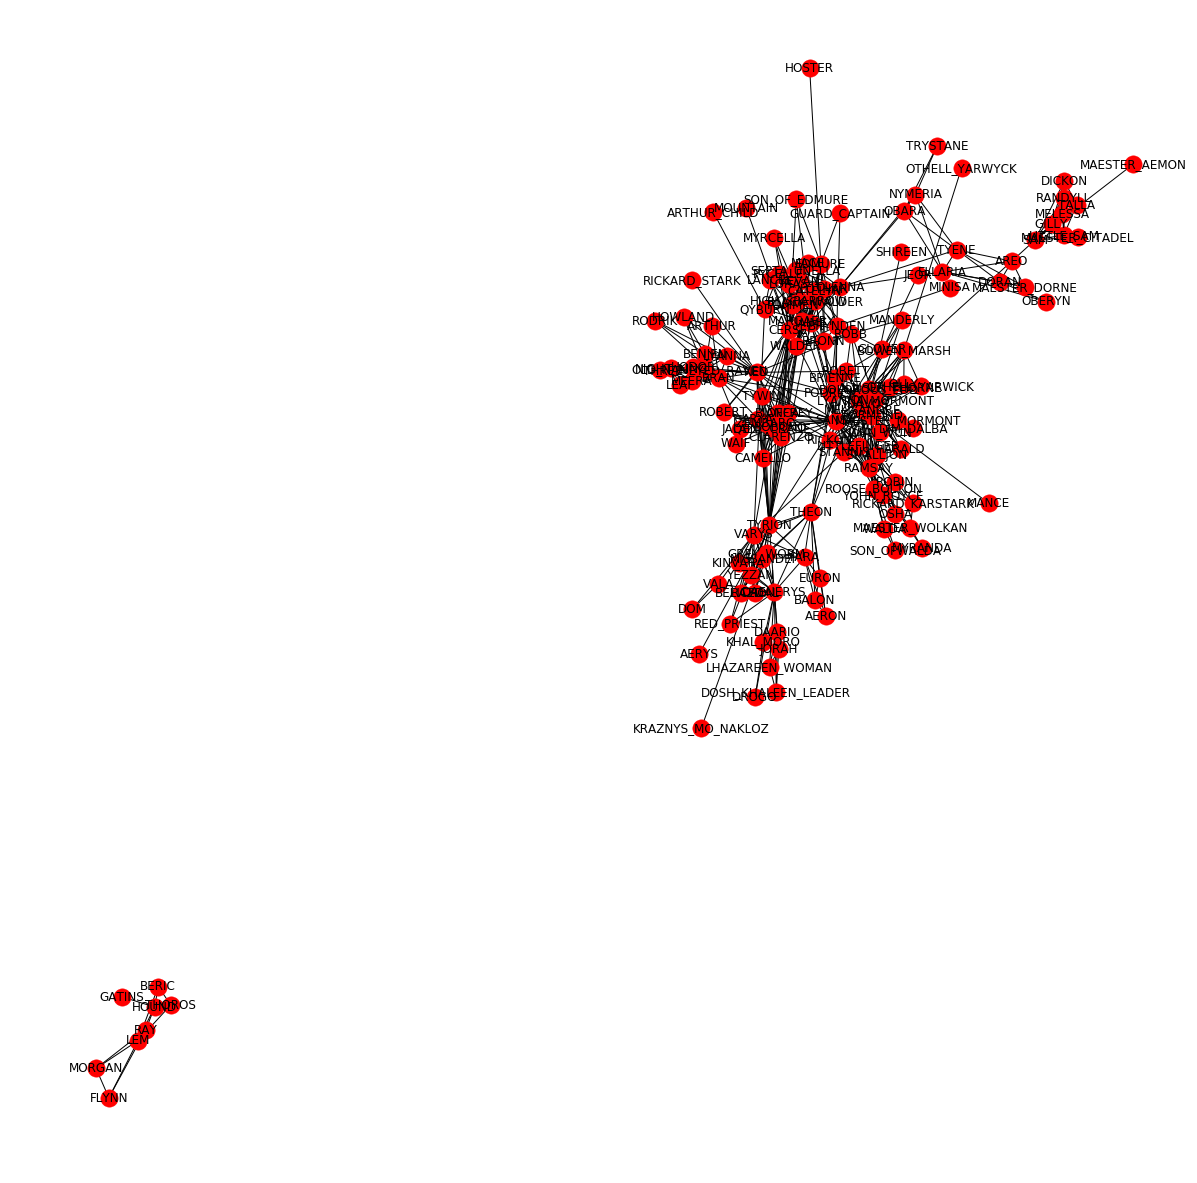

In [5]:
plt.figure(figsize=(16,16))
nx.draw(G, with_labels=True)

We see an inherent group structure in the network as well as a completely isolated island of characters not connected to any of the other characters. In general the network is somewhat dense. 

An important measure in network analysis is the so-called degree distribution. This can be visulized as a histogram of how often each degree occurs across the nodes.

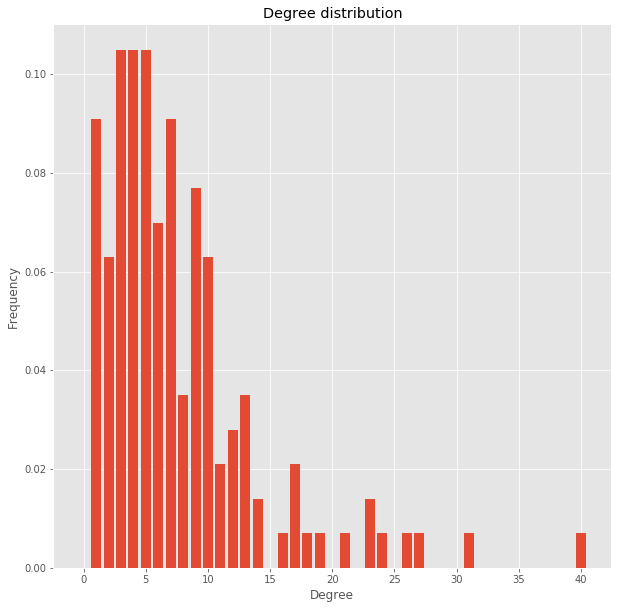

In [6]:
counts = nx.degree_histogram(G)
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(counts)), np.array(counts) / sum(counts));
plt.xlabel('Degree');
plt.ylabel('Frequency');
plt.title('Degree distribution');

We see that the distribution is a bit tail-heavy.

We investigate the characters with degree 40, to see the most popular characters.

In [7]:
degrees = sorted(G.degree(), key=lambda x : -x[1])
print(degrees[0:4])

[('SANSA', 40), ('JON', 31), ('CERSEI', 27), ('TYRION', 26)]


For people who have watched the show, this is to be expected as Sansa, Jon, Cersei and Tyrion are 4 of the main characters in the show.  

**Note**: This analysis do not take into account the weight of the edges - only the number of edges.  


Another important measure is the eigenvalue centrality. This is a measure of how influential a node is in a given network. That is, it is a scoring that measures how connected a given node is to other nodes, also of high influence. It is computed by computing the eigenvalues and eigenvectors of the adjacency matrix and looking at the nodes corresponding to high positive eigenvalues. This takes the weights of the edges into account.

In [8]:
eig_cent = sorted(nx.eigenvector_centrality_numpy(G, weight='weight').items(), key=lambda x : -x[1])
print(eig_cent[0:4])

[('JON', 0.5563530004382954), ('SANSA', 0.4857219441508337), ('DAVOS', 0.3946437655634691), ('MELISANDRE', 0.264473622152253)]


So a similar result, but with some changes. We see that although Cersei and Tyrion have interactions with more characters, the interactions of Davos and Melisandre are actually with more important characters. This is also to be expected, as Davos and Melisandre are some of the most important supporting characters.

We can also look at the distribution of the weights of the edges.

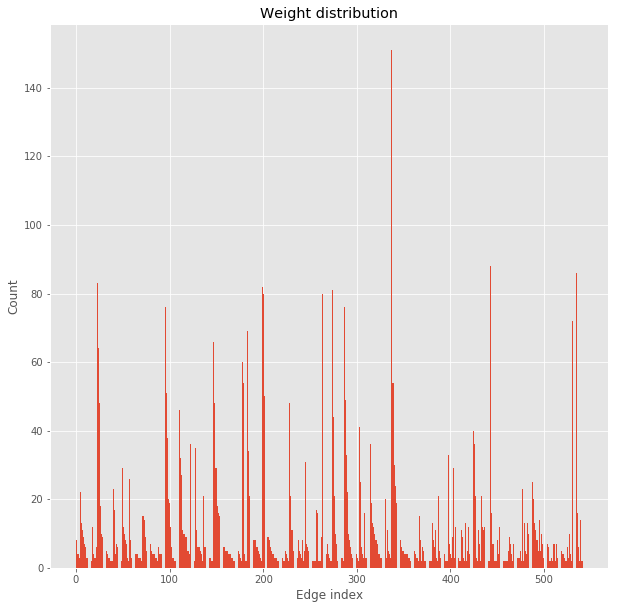

In [9]:
counts = list(zip(*G.edges.data('weight')))[-1]
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(counts)), np.array(counts));
plt.xlabel('Edge index');
plt.ylabel('Count');
plt.title('Weight distribution');

We see that there are indeed some edges that have much higher weight than others. This will be a challenge when the modelling commences. Finally, we will look at the clustering coefficients of the nodes in the network.  

The clustering coefficient is defined by so-called triangles in the network. These are sets of three nodes where all nodes are connected to eachother. The clustering coefficient is then defined by how many triangles each node is included in, and this is weighted by the (normalized) weights of the edges. This computation is done below, and the documentation can be found [here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html)

In [10]:
cluster_coefs = nx.clustering(G, weight='weight')
cc_sort = sorted(cluster_coefs.items(), key=lambda x : -x[1])
print(cc_sort[0:4])

[('WAIF', 0.13542294330453042), ('JAQEN', 0.11248912556421341), ('MAESTER_CITADEL', 0.1065092916182532), ('KINVARA', 0.10134353614958928)]


We see that these are entirely new characters compared to before. The interpretation of this is that these are part of close communities that mostly interact with itself. Visualizing the distribution, we get

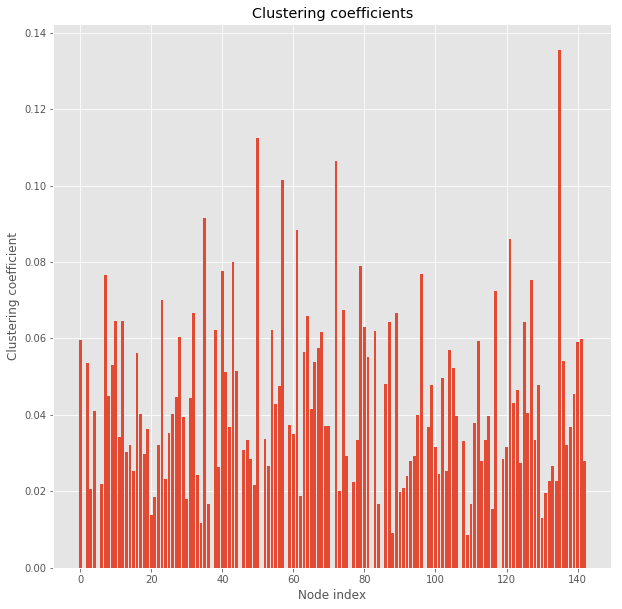

In [11]:
counts = list(zip(*cluster_coefs.items()))[-1]
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(counts)), np.array(counts));
plt.xlabel('Node index');
plt.ylabel('Clustering coefficient');
plt.title('Clustering coefficients');

This is somewhat distributed as we would expect, some high, some not as high. High clustering coefficients would lead one to believe that a group structure is indeed present in the data. Thus we believe that our idea to group the data is meaningful.  
Finally, we compute the average clustering coefficient.

In [12]:
print(f"Average clustering coefficient: {np.mean(counts)}")

Average clustering coefficient: 0.04002337438110673


Thus we have created an overview of the network for a specific season and argued why our modelling approach is indeed meaningful.